# Meta-Sampling: Estratégia de seleção de instâncias baseada em meta-aprendizado

## Elaboração de meta-base 

In [1]:
DATA_DIR = '../../metabase/'

In [55]:
%%time
import os
import numpy as np
import pandas as pd

csv_files =  [file for file in os.listdir(DATA_DIR) if file.endswith('csv')]
df_list = [pd.read_csv(os.path.join(DATA_DIR, file), index_col=False) for file in csv_files]

CPU times: user 11.6 s, sys: 554 ms, total: 12.2 s
Wall time: 12.2 s


Juntando dataframes:

In [10]:
df = pd.concat(df_list, keys=csv_files)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.index.names=['dataset', 'index']

Adicionando a informação referente à query:

In [57]:
def add_query_index(x):
    x['query_index']=range(len(x))
    return x
df = df.groupby(['dataset','estimator', 'query-strategy'], group_keys=False).apply(add_query_index)

Rotulando qual melhor estratégia para cada tripla `(dataset, estimator, query_index)` com base na acurácia:

In [12]:
meta_base = df.groupby(['dataset','estimator','query_index'], group_keys=True).apply(lambda x: x.loc[x['accuracy'].idxmax()])
meta_base.drop(['estimator', 'accuracy', 'f1-micro', 'f1-macro', 'f1-weighted','query_index'], axis=1, inplace=True)

In [13]:
meta_base

query-strategy  \
dataset        estimator              query_index                         
1005_glass.csv DecisionTreeClassifier 0            uncertainty_sampling   
                                      1                 margin_sampling   
                                      2                 margin_sampling   
                                      3                 margin_sampling   
                                      4                entropy_sampling   
...                                                                 ...   
991_car.csv    SVCLinear              95                margin_sampling   
                                      96                margin_sampling   
                                      97                margin_sampling   
                                      98                margin_sampling   
                                      99           uncertainty_sampling   

                                                   attr_conc.mean  \
dataset        estimator              query_index                   
1005_glass.csv DecisionTreeClassifier 0                  0.082414   
                                      1                  0.081938   
                                      2                  0.083475   
                                      3                  0.084567   
                                      4                  0.091017   
...                                                           ...   
991_car.csv    SVCLinear              95                 0.021034   
                                      96                 0.027452   
                                      97                 0.024350   
                                      98                 0.023121   
                                      99                 0.017146   

                                                   attr_conc.sd  \
dataset        estimator              query_index                 
1005_glass.csv DecisionTreeClassifier 0                0.064700   
                                      1                0.061594   
                                      2                0.062401   
                                      3                0.059189   
                                      4                0.066402   
...                                                         ...   
991_car.csv    SVCLinear              95               0.058361   
                                      96               0.070061   
                                      97               0.062404   
                                      98               0.059174   
                                      99               0.044504   

                                                   attr_ent.mean  attr_ent.sd  \
dataset        estimator              query_index                               
1005_glass.csv DecisionTreeClassifier 0                 2.013577     0.628029   
                                      1                 2.010002     0.636588   
                                      2                 2.010450     0.635328   
                                      3                 2.012189     0.632815   
                                      4                 2.015954     0.625010   
...                                                          ...          ...   
991_car.csv    SVCLinear              95                0.847737     0.063479   
                                      96                0.847793     0.063381   
                                      97                0.847837     0.063279   
                                      98                0.847787     0.063222   
                                      99                0.847080     0.063511   

                                                   attr_to_inst  \
dataset        estimator              query_index                 
1005_glass.csv DecisionTreeClassifier 0                0.058824   
                                      1                0

Fazendo download do arquivo:

In [6]:
meta_base.to_csv('metabase.csv')

## Treinamento de Meta-Modelo

In [14]:
meta_base =  pd.read_csv('metabase.csv', index_col=['dataset', 'estimator', 'query_index'])

Substituindo valores infinitos por `np.nan`

In [15]:
meta_base.replace([np.inf, -np.inf], np.nan, inplace=True)

Separando uma base para teste e o restante para treinamento (LOO)

In [23]:
train_index = meta_base.index.levels[0][:-1]
test_index = meta_base.index.levels[0][-1:]

len(train_index), len(test_index)

(87, 1)

Separando features e rótulos (utilizando apenas o classificador SVM)

In [24]:
train_data = meta_base.loc[train_index].xs("SVC", level='estimator').reset_index()
test_data = meta_base.loc[test_index].xs("SVC", level='estimator').reset_index()

Separando conjuntos em treino e teste

In [25]:
X_train = train_data.drop(columns=['dataset', 'query-strategy'])
y_train = train_data['query-strategy']

X_test = test_data.drop(columns=['dataset', 'query-strategy'])
y_test = test_data['query-strategy']

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6508, 180) (6508,)
(100, 180) (100,)


Induzindo modelo

In [19]:
import numpy as np 
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline



clf = Pipeline([
    ('mean_inputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('meta-model', RandomForestClassifier())
])

clf.fit(X_train, y_train)

/home/gabrielscn/.local/lib/python3.8/site-packages/sklearn/impute/_base.py:558: UserWarning: Skipping features without any observed values: ['num_to_cat']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


Pipeline(steps=[('mean_inputer', SimpleImputer()),
                ('meta-model', RandomForestClassifier())])

In [20]:
clf.predict(X_test)

/home/gabrielscn/.local/lib/python3.8/site-packages/sklearn/impute/_base.py:558: UserWarning: Skipping features without any observed values: ['num_to_cat']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


array(['consensus_entropy_sampling', 'consensus_entropy_sampling',
       'margin_sampling', 'uncertainty_batch_sampling',
       'consensus_entropy_sampling', 'consensus_entropy_sampling',
       'consensus_entropy_sampling', 'consensus_entropy_sampling',
       'consensus_entropy_sampling', 'consensus_entropy_sampling',
       'consensus_entropy_sampling', 'consensus_entropy_sampling',
       'consensus_entropy_sampling', 'consensus_entropy_sampling',
       'consensus_entropy_sampling', 'uncertainty_batch_sampling',
       'consensus_entropy_sampling', 'margin_sampling',
       'uncertainty_batch_sampling', 'uncertainty_batch_sampling',
       'uncertainty_batch_sampling', 'consensus_entropy_sampling',
       'margin_sampling', 'margin_sampling', 'uncertainty_batch_sampling',
       'uncertainty_batch_sampling', 'margin_sampling', 'margin_sampling',
       'uncertainty_batch_sampling', 'uncertainty_batch_sampling',
       'uncertainty_batch_sampling', 'uncertainty_batch_sampling',
 

## Comparando Estratégias

In [116]:
test_metrics = df.groupby(['dataset', 'estimator']).get_group((test_index[0], 'SVC')).reset_index()

### Estabelecendo uma estratégia "perfeita"

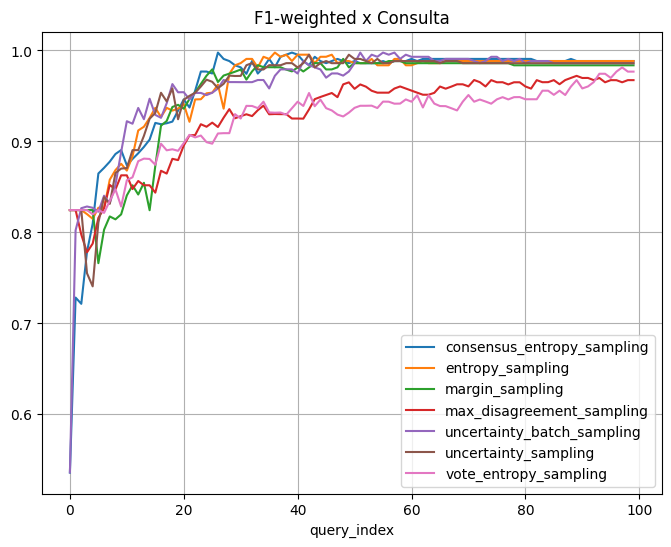

In [115]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,6))

for query_strategy, metrics in test_metrics.groupby('query-strategy'):
    metrics.plot(ax=ax, label=query_strategy, x='query_index', y='f1-weighted', grid=True, title="F1-weighted x Consulta" )

In [67]:
test_index[0]

'991_car.csv'